In [1]:
from pyspark.sql import SparkSession

#Read csv with Spark
spark = SparkSession.builder \
    .appName("Weather ANN") \
    .getOrCreate()
df = spark.read.parquet("/daily_weather.parquet")
df.show(2)

+----------+---------+-------------------+------+----------+----------+----------+----------------+-------------+----------------+------------------+------------------+----------------------+------------------+-----------------+
|station_id|city_name|               date|season|avg_temp_c|min_temp_c|max_temp_c|precipitation_mm|snow_depth_mm|avg_wind_dir_deg|avg_wind_speed_kmh|peak_wind_gust_kmh|avg_sea_level_pres_hpa|sunshine_total_min|__index_level_0__|
+----------+---------+-------------------+------+----------+----------+----------+----------------+-------------+----------------+------------------+------------------+----------------------+------------------+-----------------+
|     41515| Asadabad|1957-07-01 01:00:00|Summer|      27.0|      21.1|      35.6|             0.0|         null|            null|              null|              null|                  null|              null|                0|
|     41515| Asadabad|1957-07-02 01:00:00|Summer|      22.8|      18.9|      32.2|  

In [2]:
from pyspark.sql import SparkSession

#Selecting columns
selected_columns = ['avg_temp_c', 'min_temp_c', 'max_temp_c', 'season']
df = df.select(selected_columns)

# Show first 3
df.show(3)

+----------+----------+----------+------+
|avg_temp_c|min_temp_c|max_temp_c|season|
+----------+----------+----------+------+
|      27.0|      21.1|      35.6|Summer|
|      22.8|      18.9|      32.2|Summer|
|      24.3|      16.7|      35.6|Summer|
+----------+----------+----------+------+
only showing top 3 rows



In [3]:
# Count the distinct seasons in the dataset
distinct_season_count = df.select("season").distinct().count()

# Print the number of unique seasons
print(f"Datasetinde {distinct_season_count} çeşit sezon bulunmaktadır.")

# Display the distinct seasons
s = df.select("season").distinct()
s.show()

Datasetinde 4 çeşit sezon bulunmaktadır.


+------+
|season|
+------+
|Spring|
|Summer|
|Autumn|
|Winter|
+------+



In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql import Row

# Create a SparkSession
spark = SparkSession.builder.appName("OneHotEncoding").getOrCreate()

# Sample data
data = [Row(season="Spring"),
        Row(season="Summer"),
        Row(season="Autumn"),
        Row(season="Winter")]

df_season = spark.createDataFrame(data)

# Use StringIndexer to convert seasons to numbers
indexer = StringIndexer(inputCol="season", outputCol="seasonIndex")
indexed = indexer.fit(df_season).transform(df_season)

# Apply OneHotEncoding
encoder = OneHotEncoder(inputCol="seasonIndex", outputCol="seasonVec")
encoded = encoder.fit(indexed).transform(indexed)
encoded.show()

+------+-----------+-------------+
|season|seasonIndex|    seasonVec|
+------+-----------+-------------+
|Spring|        1.0|(3,[1],[1.0])|
|Summer|        2.0|(3,[2],[1.0])|
|Autumn|        0.0|(3,[0],[1.0])|
|Winter|        3.0|    (3,[],[])|
+------+-----------+-------------+



In [5]:
# Merge 'df' and 'encoded' dataframes based on the 'season' column
merged_df = df.join(encoded, on='season', how='left')

# Display the first few rows
merged_df.show(3)

+------+----------+----------+----------+-----------+-------------+
|season|avg_temp_c|min_temp_c|max_temp_c|seasonIndex|    seasonVec|
+------+----------+----------+----------+-----------+-------------+
|Summer|      27.0|      21.1|      35.6|        2.0|(3,[2],[1.0])|
|Summer|      22.8|      18.9|      32.2|        2.0|(3,[2],[1.0])|
|Summer|      24.3|      16.7|      35.6|        2.0|(3,[2],[1.0])|
+------+----------+----------+----------+-----------+-------------+
only showing top 3 rows



In [6]:
# Select only the specified columns.
selected_df = merged_df.select( 'avg_temp_c', 'min_temp_c', 'max_temp_c', 'seasonIndex')

# Display the first few rows
selected_df.show(3)

+----------+----------+----------+-----------+
|avg_temp_c|min_temp_c|max_temp_c|seasonIndex|
+----------+----------+----------+-----------+
|      27.0|      21.1|      35.6|        2.0|
|      22.8|      18.9|      32.2|        2.0|
|      24.3|      16.7|      35.6|        2.0|
+----------+----------+----------+-----------+
only showing top 3 rows



In [7]:
# Remove any rows with null or NaN values
selected_df = selected_df.dropna()
selected_df.show()

+----------+----------+----------+-----------+
|avg_temp_c|min_temp_c|max_temp_c|seasonIndex|
+----------+----------+----------+-----------+
|       7.4|       5.0|      12.2|        1.0|
|       5.8|       2.2|      12.8|        1.0|
|     -10.1|     -16.4|      -4.0|        1.0|
|       6.6|       1.1|      16.1|        1.0|
|      -6.8|     -11.5|      -3.7|        1.0|
|       7.1|       1.7|      14.4|        1.0|
|      -4.3|      -6.8|      -1.4|        1.0|
|      -0.6|      -2.5|       1.2|        1.0|
|      11.4|       6.1|      18.3|        1.0|
|      10.7|       9.4|      13.3|        1.0|
|      -2.2|      -6.3|       2.7|        1.0|
|       7.9|       5.6|      13.3|        1.0|
|       9.3|       4.4|      15.0|        1.0|
|       8.9|       3.9|      18.3|        1.0|
|       8.7|       6.7|      17.2|        1.0|
|       9.8|       5.0|      21.1|        1.0|
|      -8.0|     -14.2|      -3.0|        1.0|
|      12.3|       6.1|      20.6|        1.0|
|      12.8| 

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Convert the features into a vector
vectorAssembler = VectorAssembler(inputCols=["avg_temp_c", "min_temp_c", "max_temp_c"], outputCol="features")
df = vectorAssembler.transform(selected_df)

# Index the categorical label
labelIndexer = StringIndexer(inputCol="seasonIndex", outputCol="label").fit(selected_df)
df = labelIndexer.transform(selected_df)

In [ ]:
# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

# Define the architecture for the MLP model
num_labels = train_data.select("label").distinct().count()
layers = [3, 5, 5, num_labels]

mlp = MultilayerPerceptronClassifier(
    layers=layers, 
    blockSize=128, 
    seed=1234, 
    maxIter=100, 
    featuresCol="features", 
    labelCol="label"
)

# Train the model
model = mlp.fit(train_data)

# Make predictions
train_predictions = model.transform(train_data)
test_predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(train_predictions)
test_accuracy = evaluator.evaluate(test_predictions)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Convert the features into a vector
vectorAssembler = VectorAssembler(inputCols=["avg_temp_c", "min_temp_c", "max_temp_c"], outputCol="features")
df = vectorAssembler.transform(selected_df)

# Index the categorical label
labelIndexer = StringIndexer(inputCol="seasonIndex", outputCol="label").fit(selected_df)
df = labelIndexer.transform(df)


In [10]:
# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

# Define the architecture for the MLP model
num_labels = train_data.select("label").distinct().count()
layers = [3, 5, 5, num_labels]

mlp = MultilayerPerceptronClassifier(
    layers=layers, 
    blockSize=128, 
    seed=1234, 
    maxIter=100, 
    featuresCol="features", 
    labelCol="label"
)

# Train the model
model = mlp.fit(train_data)

# Make predictions
train_predictions = model.transform(train_data)
test_predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(train_predictions)
test_accuracy = evaluator.evaluate(test_predictions)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


2023-10-10 22:12:33,622 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 70.8 MiB so far)
2023-10-10 22:12:33,627 WARN storage.BlockManager: Persisting block rdd_147_2 to disk instead.
2023-10-10 22:12:34,156 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 70.8 MiB so far)
2023-10-10 22:12:34,157 WARN storage.BlockManager: Persisting block rdd_147_0 to disk instead.
2023-10-10 22:12:34,864 WARN memory.MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 70.8 MiB so far)
2023-10-10 22:12:34,865 WARN storage.BlockManager: Persisting block rdd_147_1 to disk instead.
2023-10-10 22:12:36,821 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 106.2 MiB so far)
2023-10-10 22:12:37,443 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 106.2 MiB so far)
2023-10-10 22:12:38,259 WARN memory.MemoryStore: Not enough space to cache rdd_147_1 in memory! (c

2023-10-10 22:13:45,231 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 47.1 MiB so far)
2023-10-10 22:13:45,253 WARN memory.MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 70.8 MiB so far)
2023-10-10 22:13:45,258 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 70.8 MiB so far)
2023-10-10 22:13:48,540 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 47.1 MiB so far)
2023-10-10 22:13:48,773 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 70.8 MiB so far)
2023-10-10 22:13:48,774 WARN memory.MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 70.8 MiB so far)
2023-10-10 22:13:52,386 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 47.1 MiB so far)
2023-10-10 22:13:52,406 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 70.8 MiB so far)
2023-10-10 22:13

2023-10-10 22:16:09,003 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 47.1 MiB so far)
2023-10-10 22:16:09,024 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 70.8 MiB so far)
2023-10-10 22:16:09,027 WARN memory.MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 70.8 MiB so far)
2023-10-10 22:16:13,913 WARN memory.MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 47.1 MiB so far)
2023-10-10 22:16:13,956 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 70.8 MiB so far)
2023-10-10 22:16:14,075 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 70.8 MiB so far)
2023-10-10 22:16:19,846 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 47.1 MiB so far)
2023-10-10 22:16:19,862 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 70.8 MiB so far)
2023-10-10 22:16

2023-10-10 22:17:30,640 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 47.1 MiB so far)
2023-10-10 22:17:30,693 WARN memory.MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 70.8 MiB so far)
2023-10-10 22:17:30,701 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 70.8 MiB so far)
2023-10-10 22:17:34,157 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 47.1 MiB so far)
2023-10-10 22:17:34,190 WARN memory.MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 70.8 MiB so far)
2023-10-10 22:17:34,192 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 70.8 MiB so far)
2023-10-10 22:17:38,003 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 47.1 MiB so far)
2023-10-10 22:17:38,024 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 70.8 MiB so far)
2023-10-10 22:17

2023-10-10 22:18:45,991 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 47.1 MiB so far)
2023-10-10 22:18:46,013 WARN memory.MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 70.8 MiB so far)
2023-10-10 22:18:46,052 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 70.8 MiB so far)
2023-10-10 22:18:49,370 WARN memory.MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 47.1 MiB so far)
2023-10-10 22:18:49,391 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 70.8 MiB so far)
2023-10-10 22:18:49,392 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 70.8 MiB so far)
2023-10-10 22:18:52,648 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 47.1 MiB so far)
2023-10-10 22:18:52,716 WARN memory.MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 70.8 MiB so far)
2023-10-10 22:18

2023-10-10 22:19:59,411 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 47.1 MiB so far)
2023-10-10 22:19:59,438 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 70.8 MiB so far)
2023-10-10 22:19:59,490 WARN memory.MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 70.8 MiB so far)
2023-10-10 22:20:02,723 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 47.1 MiB so far)
2023-10-10 22:20:02,742 WARN memory.MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 70.8 MiB so far)
2023-10-10 22:20:02,747 WARN memory.MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 70.8 MiB so far)
2023-10-10 22:20:06,258 WARN memory.MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 47.1 MiB so far)
2023-10-10 22:20:06,279 WARN memory.MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 70.8 MiB so far)
2023-10-10 22:20

Training Accuracy: 43.46%
Test Accuracy: 43.49%


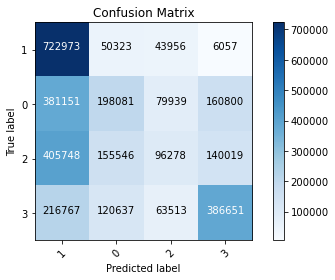

In [15]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Use int() to round the float value to the nearest integer
        plt.text(j, i, str(int(cm[i, j])),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Assuming you've already computed the confusion_matrix and classes from the previous code snippets
plot_confusion_matrix(confusion_matrix, classes)

